In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import geopandas as gpd
import pandas as pd
import math

In [2]:
#Read in LA neighborhood map
#Retrieved from http://boundaries.latimes.com/set/la-county-neighborhoods-current/
nbd= gpd.read_file("data/la-county-neighborhoods-current.geojson")

In [3]:
##GEO LABELING setup
#Read in LA county regions - for use in labeling
regs = gpd.read_file("data/la-county-regions-current.geojson")
#regs
regsd = regs.drop([0, 5, 6, 7, 10,14]) #Keep only desired regions

#Rename Central LA Hollywood to better match its centroid
d = {'Central L.A.':'Hollywood'}
regsd = regsd.replace(d)
regsd

#Store Long Beach centroid to use for plotting 'Harbor' data label - so that it's not in the ocean, due to Catalina
nbd[nbd['name'].str.contains('Long Beach')].geometry.centroid
longbeach = (-118.16071, 33.80522)

In [6]:
def daily_map(mm, dd, usemax=0, labels=False):
    
    month = str(mm).zfill(2)
    day = str(dd).zfill(2)

    #Read in daily update
    #Retrieved from http://publichealth.lacounty.gov/media/Coronavirus/locations.htm
    dailyrep = pd.read_csv('data/covid_'+month+day+'.csv')

    #Find values of note: number under investigation, total
    underinv = dailyrep[dailyrep['city'].str.contains('Under Investigation')]['count'].item()
    nconfirmed = dailyrep[dailyrep['city'].str.contains('Total')]['count'].item()
    
    #Use a persistent scalebar across plots
    if usemax:
        vmax = usemax
    else:
        vmax = dailyrep[~dailyrep["city"].str.contains("Under Investigation") & ~dailyrep["city"].str.contains("Total")]['count'].max()
        print('Normalizing to', vmax, '\n For context:', dailyrep.nlargest(5,'count'))
        
    #Add geographic information for neighborhoods
    merged = nbd.set_index('name').join(dailyrep.set_index('city'))

    #Plot
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    nbd.plot(ax=ax, color='#eeeeee',edgecolor='white', linewidth=1)
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05) #cax1 = divider.append_axes("bottom", size="5%", pad=-3)
    ax = merged.plot(column='count', vmin =0, vmax = vmax, cmap='Reds', ax=ax, cax=cax1, legend=True,edgecolor='white', linewidth=0.4)#legend_kwds={"aspect":"10"})#orientation": "horizontal"})
    
    #Add labels for case counts
    # merged.apply(lambda x: ax.annotate(x.count(), xy=x.geometry.centroid.coords[0], ha='center'),axis=1);    
    for idx, row in merged.iterrows():
        if not math.isnan(row['count']):
            if (row.external_id=='long-beach'):
                ha = 'left'
                ax.annotate(s='  '+str(int(row['count'])), xy=row.geometry.centroid.coords[0], horizontalalignment=ha,color=color, fontsize=6, weight='bold')
            else:
                ha = 'center'
                color='white'
                ax.annotate(s=int(row['count']), xy=row.geometry.centroid.coords[0], horizontalalignment=ha, color=color, fontsize=6, weight='bold')

    #Add labels for regions
    # regsd.plot(facecolor='b',edgecolor='k', linewidth=1, ax=ax, alpha = 0.2) #Plot region boundaries
    if labels:
        for idx, row in regsd.iterrows():
            if (idx==2):
                fs = 8
                ax.annotate(s=row['name'], xy=row.geometry.centroid.coords[0], horizontalalignment='center', color='#767676', fontsize=fs, alpha = 0.95, weight='bold')
            elif (idx==4):
                fs=11
                ax.annotate(s=row['name'], xy=longbeach, horizontalalignment='right', verticalalignment='top', color='#767676', fontsize=fs, alpha = 0.95, weight='bold')
            else:
                fs = 11
                ax.annotate(s=row['name'], xy=row.geometry.centroid.coords[0], horizontalalignment='center', color='#767676', fontsize=fs, alpha = 0.95, weight='bold')

    #Adjust plot display
    ax.set_ylim([33.65, 34.9])
    ax.axis('off')
    ax.set_title('Confirmed COVID-19 Cases in LA County \n \n '+month+'/'+day+'/2020', fontdict={'fontsize': '20', 'fontweight' : 'demibold'})
    ax.annotate('Total: '+str(nconfirmed),xy=(0.1, .14),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=16, color='k', weight='demibold')
    ax.annotate('Under investigation: '+str(underinv)+' (not shown)',xy=(0.1, .11),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=16, color='k')#, weight='demibold')
    ax.annotate('Source: Los Angeles County Department of Public Health',xy=(0.1, .05),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    fig.savefig('maps/covid_la_'+month+day+'.png',dpi=300, bbox_inches = 'tight')

    return vmax

Normalizing to 47 
 For context:                     city  count
157                Total   1216
154  Under Investigation    141
79               Melrose     47
14             Brentwood     42
155           Long Beach     41


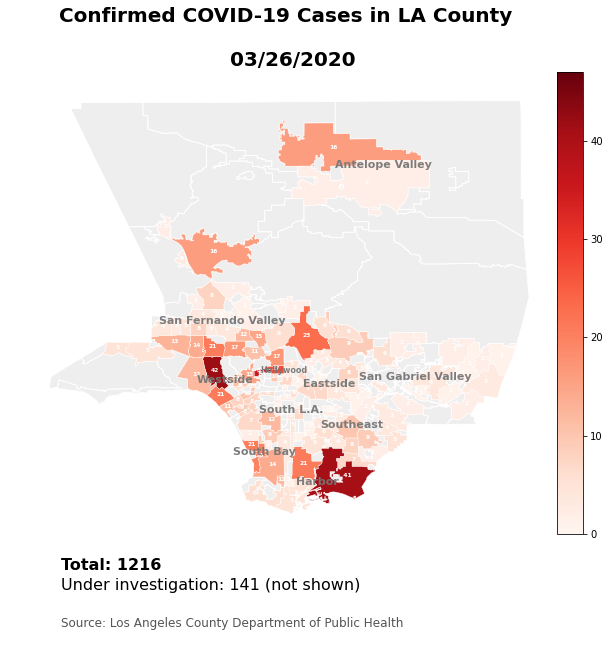

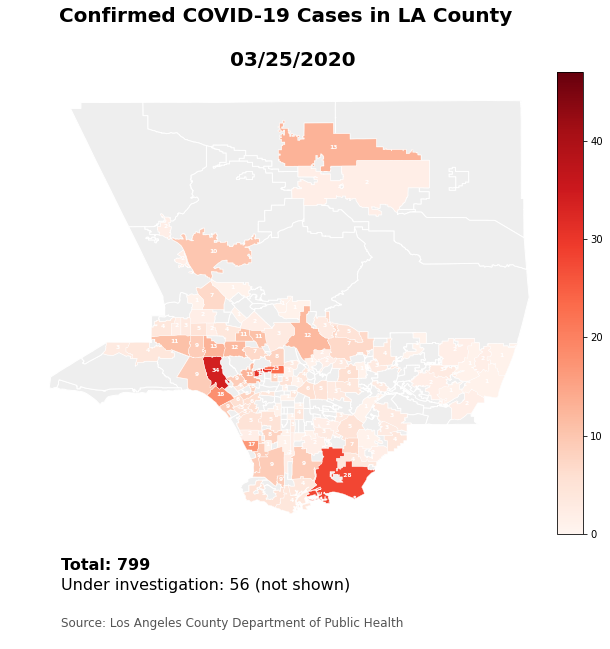

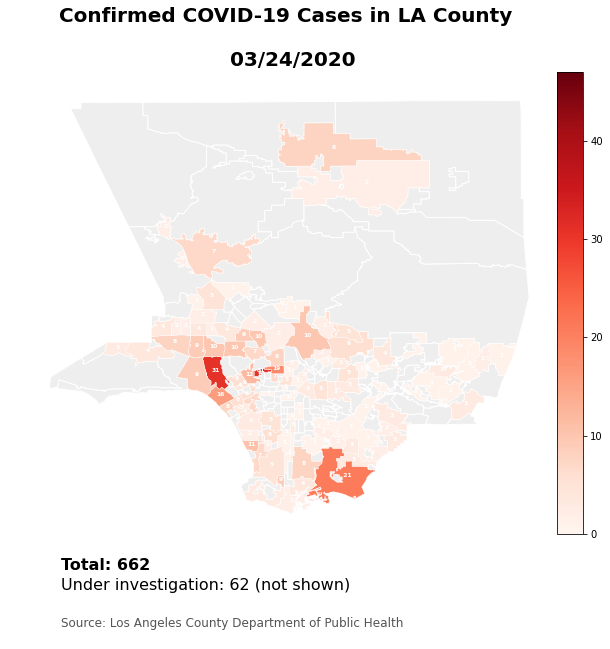

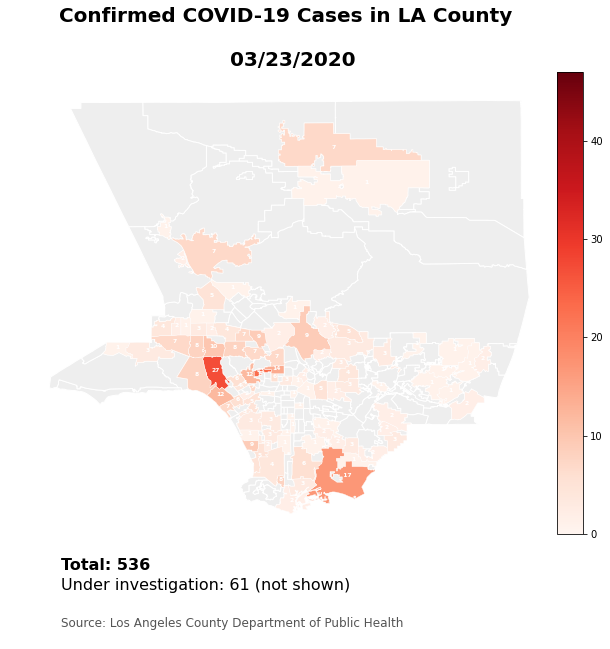

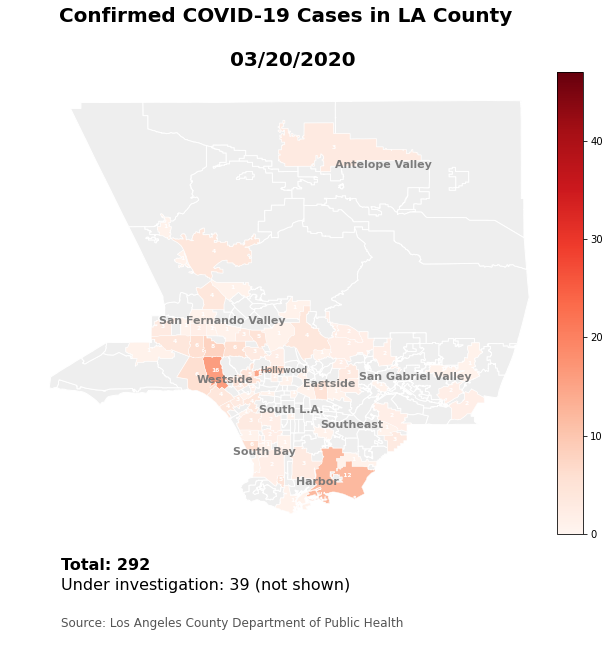

In [7]:
#Create plots for the specified days
month = 3
days = [20, 23, 24, 25,26]

vmax = 0
for idx,day in enumerate(reversed(days)):
    if (idx==0):
        vmax = daily_map(month,day, usemax=False, labels=True)
    else:
        if (idx==len(days)-1):
            daily_map(month,day, usemax=vmax, labels=True)
        else:
            daily_map(month,day, usemax=vmax)

To create an animated gif, use imagemagick locally.  Currently using:

convert -delay 90 -loop 0 *png covid_la.gif


In [ ]:
#Test out plotting a barchart
fig, ax = plt.subplots(1,1, figsize=(12, 20))
df = pd.read_csv('data/covid_0324.csv')
df.set_index('city', inplace=True, drop=True)
df.drop(['Under Investigation']).sort_values(by=['count'],ascending=1).plot(kind='barh', ax=ax, legend=False)
df['count'].max()